In [ ]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip

fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fake-and-real-news-dataset.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!pip install fasttext

In [ ]:
!pip install torchmetrics

In [219]:
import pandas as pd
from nltk import word_tokenize
from tqdm import tqdm
from collections import Counter
import nltk
import seaborn as sns
from matplotlib import pyplot as plt
from string import punctuation
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.nn as nn
import numpy as np
import fasttext
from sklearn.metrics import f1_score
from torchmetrics.functional import accuracy

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data = pd.read_csv('Fake.csv')

data['text'] = data.apply(lambda row: '{} {}'.format(row[0], row[1]), axis=1)
data = data.drop(columns=['title', 'date'])
data['subject'] = data['subject'].astype('category').cat.codes

In [ ]:
def preprocess(text):
    text = [token for token in word_tokenize(text.lower()) if token not in punctuation]
    return text

In [ ]:
vocab = Counter()
lengths = []

for text in tqdm(data.text):
    words = preprocess(text)
    lengths.append(len(words))
    vocab.update(words)

100%|██████████| 23481/23481 [01:19<00:00, 293.53it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


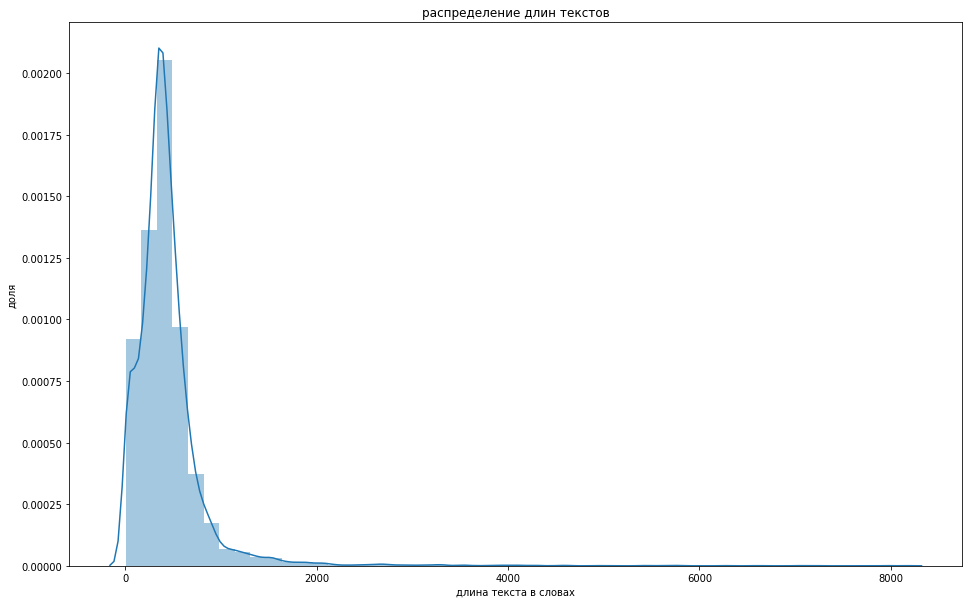

In [ ]:
plt.figure(figsize=(16, 10))
plt.title('распределение длин текстов')
plt.xlabel('длина текста в словах')
plt.ylabel('доля')
sns.distplot(lengths)

In [ ]:
perc = round(len([l for l in lengths if l > 512]) / len(lengths), 2) * 100
print('доля текстов длиннее 512 слов:', str(perc) + '%')

доля текстов длиннее 512 слов: 27.0%


In [ ]:
print('средняя длина 1 текста в словах:', round(sum(lengths) / len(lengths)))

средняя длина 1 текста в словах: 441


In [ ]:
# пока что нет никакой фильтрации по частотности слов
word2id = {'PAD': 0}
for word in tqdm(vocab.keys()):
    word2id[word] = len(word2id)

100%|██████████| 184868/184868 [00:00<00:00, 1254335.53it/s]


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2021-12-29 14:59:35--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz      1%[                    ]  63.77M  16.2MB/s    eta 4m 34s ^C


In [ ]:
!gzip -d cc.en.300.bin.gz

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
vectors = np.zeros((len(word2id), 300))
for word, i in tqdm(word2id.items()):
    if word == 'PAD':
        continue   
    try:
        vectors[i] = ft[word]
    except KeyError:
        vectors[i] = np.random.uniform(-0.25,0.25,300)

100%|██████████| 184869/184869 [00:03<00:00, 57870.39it/s]


In [ ]:
del ft

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = []
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['subject'].values
        self.load(dataset['text'].values)
        self.device = DEVICE


    def __len__(self):
        return self.length


    @staticmethod
    def preprocess(text):
        text = [token for token in word_tokenize(text.lower()) if token not in punctuation]
        return text


    def load(self, texts, verbose=True):
        data_iterator = tqdm(texts, desc='loading data', disable=not verbose)
        for text in data_iterator:
            words = self.preprocess(text)
            self.dataset.append(words)

    
    def indexing(self, tokenized_text):
        return [self.word2id[word] for word in tokenized_text if word in self.word2id]


    def __getitem__(self, index): 
        words = list(self.dataset[index])
        x = torch.cuda.LongTensor(self.indexing(words[:1024]))
        y = self.target[index]
        return x, y


    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [263]:
train_data, val_data = train_test_split(data, test_size=0.2)

In [264]:
train_dataset = NewsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=256)

loading data: 100%|██████████| 18784/18784 [01:00<00:00, 312.26it/s]


In [199]:
val_dataset = NewsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=256)

loading data: 100%|██████████| 4697/4697 [00:22<00:00, 212.23it/s]


In [265]:
n_cats = len(data['subject'].unique())

In [266]:
class CLSTM(nn.Module):
    def __init__(self, vectors, n_cats=6, p1=0.5, p2=0.5, embedding_dim=300, 
                 out_channels=150, kernel_size=3, padding='same',
                 hidden_size=150, num_layers=1,
                 bidirectional=False, ngrams_sec=False, in_channels_sec=None,
                 out_channels_sec=None, kernel_size_sec=None):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(vectors), freeze=False)
        self.dropout1 = nn.Dropout(p=p1)

        self.ngrams = nn.Conv1d(in_channels=embedding_dim, 
                                  out_channels=out_channels, 
                                  kernel_size=kernel_size, 
                                  padding=padding)
        
        self.ngrams_sec = ngrams_sec
        if self.ngrams_sec:
            self.ngrams_second = nn.Conv1d(in_channels=in_channels_sec, 
                                    out_channels=out_channels_sec, 
                                    kernel_size=kernel_size_sec, 
                                    padding=padding)
        
        self.relu = nn.ReLU()
        
        self.LSTM = nn.LSTM(input_size=out_channels,
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  bidirectional=bidirectional,
                                  batch_first=True)
        
        self.dropout2 = nn.Dropout(p=p2)

        self.out = nn.Linear(hidden_size, n_cats)
        
        

    def forward(self, word):
        x = self.embedding(word)
        x = x.transpose(1,2)
        x = self.dropout1(x)
        x = self.ngrams(x)
        x = self.relu(x)
        if self.ngrams_sec:
            x2 = self.ngrams(x)
            x2 = self.relu(x2)
        x = x.transpose(1,2)
        o_n, (h_n, c_n) = self.LSTM(x)
        x = self.dropout2(h_n)
        x = x.squeeze(0)
        x = self.out(x)

        return x

In [267]:
def training(model, iterator, optimizer, criterion):
    epoch_loss = 0 

    model.train()

    for i, (texts, ys) in enumerate(iterator): 
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return  model, epoch_loss / len(iterator)

In [268]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys.long())
            epoch_loss += loss.item()
            batch_metric = accuracy(preds, ys.long())
            epoch_metric += batch_metric.item()
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [272]:
model = CLSTM(vectors)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
print(model)
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

CLSTM(
  (embedding): Embedding(184869, 300)
  (dropout1): Dropout(p=0.5, inplace=False)
  (ngrams): Conv1d(300, 150, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (LSTM): LSTM(150, 150, batch_first=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=150, out_features=6, bias=True)
)


In [273]:
losses = []
losses_eval = []
accs = []
accs_eval = []

for i in tqdm(range(10)):
    print(f'\nepoch {i}')
    model, epoch_loss = training(model, train_iterator, optimizer, criterion)
    print('epoch loss on train:', epoch_loss)
    losses.append(epoch_loss)
    print('\ntest evaluation:')
    acc_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    print('\nepoch loss on test:', epoch_loss_on_test)
    print('accuracy on test:', acc_on_test)
    print('--------------------')
    losses_eval.append(epoch_loss_on_test)
    accs_eval.append(acc_on_test)

  0%|          | 0/10 [00:00<?, ?it/s]


epoch 0
epoch loss on train: 1.5771029124388825

test evaluation:


 10%|█         | 1/10 [00:21<03:13, 21.50s/it]


epoch loss on test: 1.430844181462338
accuracy on test: 0.3884258568286896
--------------------

epoch 1
epoch loss on train: 1.4458734264244903

test evaluation:


 20%|██        | 2/10 [00:42<02:51, 21.42s/it]


epoch loss on test: 1.4319347456881875
accuracy on test: 0.3876034884076369
--------------------

epoch 2
epoch loss on train: 1.4299111833443512

test evaluation:


 30%|███       | 3/10 [01:04<02:30, 21.43s/it]


epoch loss on test: 1.415146124990363
accuracy on test: 0.39109855419711065
--------------------

epoch 3
epoch loss on train: 1.4345349137847487

test evaluation:


 40%|████      | 4/10 [01:25<02:08, 21.39s/it]


epoch loss on test: 1.4146311345853304
accuracy on test: 0.39438802788132116
--------------------

epoch 4
epoch loss on train: 1.4292172451277037

test evaluation:


 50%|█████     | 5/10 [01:47<01:47, 21.41s/it]


epoch loss on test: 1.3699994965603477
accuracy on test: 0.3943626190486707
--------------------

epoch 5
epoch loss on train: 1.2939784397950043

test evaluation:


 60%|██████    | 6/10 [02:08<01:25, 21.45s/it]


epoch loss on test: 1.2034794405887002
accuracy on test: 0.3970353164170918
--------------------

epoch 6
epoch loss on train: 1.2397967834730406

test evaluation:


 70%|███████   | 7/10 [02:30<01:04, 21.44s/it]


epoch loss on test: 1.1265621812720048
accuracy on test: 0.3966495410392159
--------------------

epoch 7
epoch loss on train: 1.2265667351516518

test evaluation:


 80%|████████  | 8/10 [02:51<00:42, 21.43s/it]


epoch loss on test: 1.0852257452513043
accuracy on test: 0.5637220018788388
--------------------

epoch 8
epoch loss on train: 1.2119396651113354

test evaluation:


 90%|█████████ | 9/10 [03:12<00:21, 21.39s/it]


epoch loss on test: 1.0370407073121322
accuracy on test: 0.6829700438599837
--------------------

epoch 9
epoch loss on train: 1.2103746291753408

test evaluation:


100%|██████████| 10/10 [03:34<00:00, 21.43s/it]


epoch loss on test: 1.0494876535315263
accuracy on test: 0.6844345989980196
--------------------


In [249]:
model

CLSTM(
  (embedding): Embedding(184869, 300)
  (dropout1): Dropout(p=0.5, inplace=False)
  (ngrams): Conv1d(300, 150, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (LSTM): LSTM(150, 150, batch_first=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=150, out_features=6, bias=True)
)